In [210]:
import pandas as pd
import seaborn as sns
import numpy as np
from nltk.tokenize import regexp_tokenize
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from collections import defaultdict
import re, nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.patches as mpatches
import random
from sklearn import metrics
import re
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.tree import DecisionTreeClassifier
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag, corpus

In [211]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Packag

True

In [212]:
#UMICH SI650 - Sentiment Classification
#https://www.kaggle.com/competitions/si650winter11/data

In [213]:
#Read test and train datasets
# header=0 -> first line contains column names
# delimiter=\t -> fields are separated by tabs
# quoting=3 -> ignore double quotes

train_data_df  = pd.read_table('si650winter11/training.txt', names=['sentiment', 'comment'], header=None, delimiter="\t", quoting=3)
test_data_df  = pd.read_table('si650winter11/testdata.txt', names=['comment'], header=None, delimiter="\t", quoting=3)

In [214]:
test_data_df.head(5)

,comment
0,""" I don't care what anyone says, I like Hillar..."
1,have an awesome time at purdue!..
2,"Yep, I'm still in London, which is pretty awes..."
3,"Have to say, I hate Paris Hilton's behavior bu..."
4,i will love the lakers.


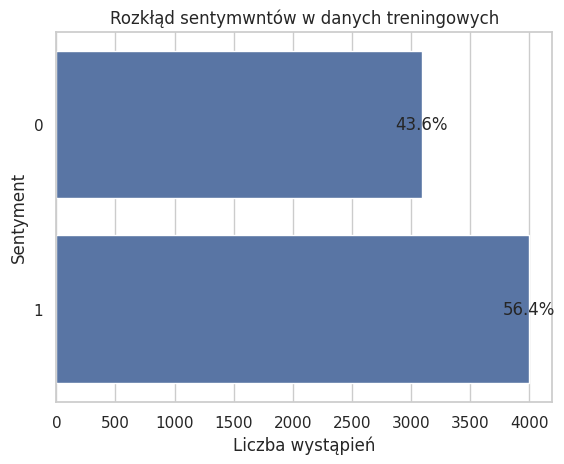

In [215]:
ax = sns.countplot(y="sentiment", data=train_data_df)
ax.set(title="Rozkłąd sentymwntów w danych treningowych", xlabel="Liczba wystąpień", ylabel="Sentyment")
total_freq = len(train_data_df)
for p in ax.patches:
    percentage = f'{100 * p.get_width() / total_freq:.1f}%'
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.show()

In [216]:
#number words per sentence
np.mean([len(s.split(" ")) for s in train_data_df.comment])

10.886819079875812

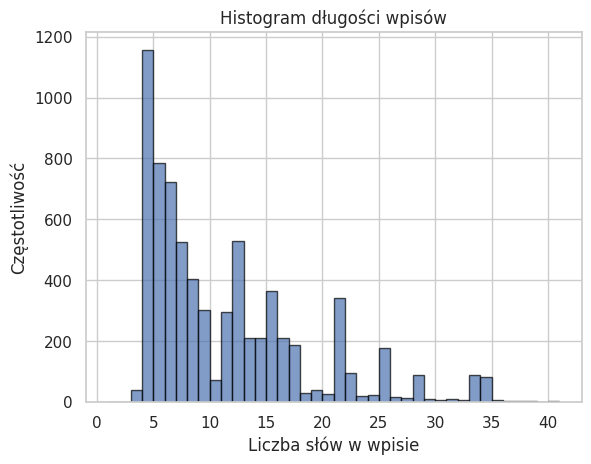

In [217]:
#Make a frequency list of lengths of tokenized each sentences
list_freq = [len(regexp_tokenize(s, "\w+")) for s in train_data_df["comment"]]

# Plot a histogram of the line lengths
#plt.figure(figsize=(8, 6))  # Ustawienie rozmiaru figury
plt.hist(list_freq, bins=range(1, max(list_freq) + 2), edgecolor='black', alpha=0.7)
plt.title("Histogram długości wpisów")
plt.xlabel("Liczba słów w wpisie")
plt.ylabel("Częstotliwość")
plt.show()

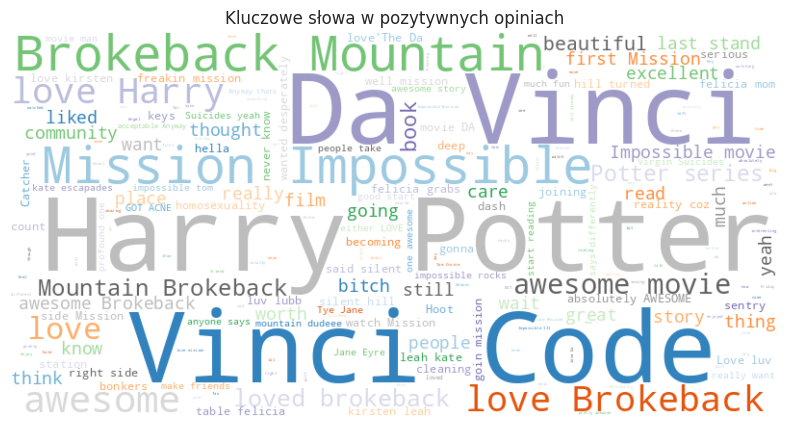

In [218]:
positive_comments = train_data_df[train_data_df['sentiment']==1]['comment']
text = " ".join(review for review in positive_comments)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab20c').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Kluczowe słowa w pozytywnych opiniach")
plt.axis('off')
plt.show()

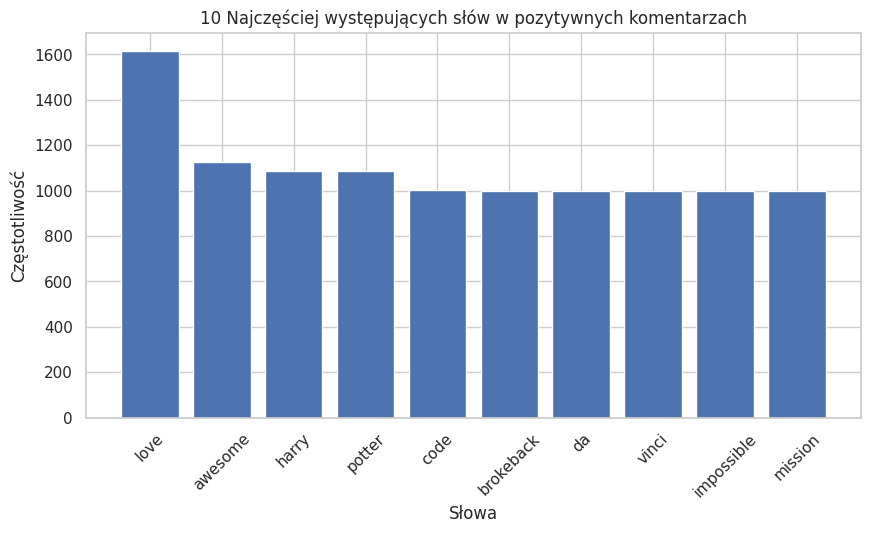

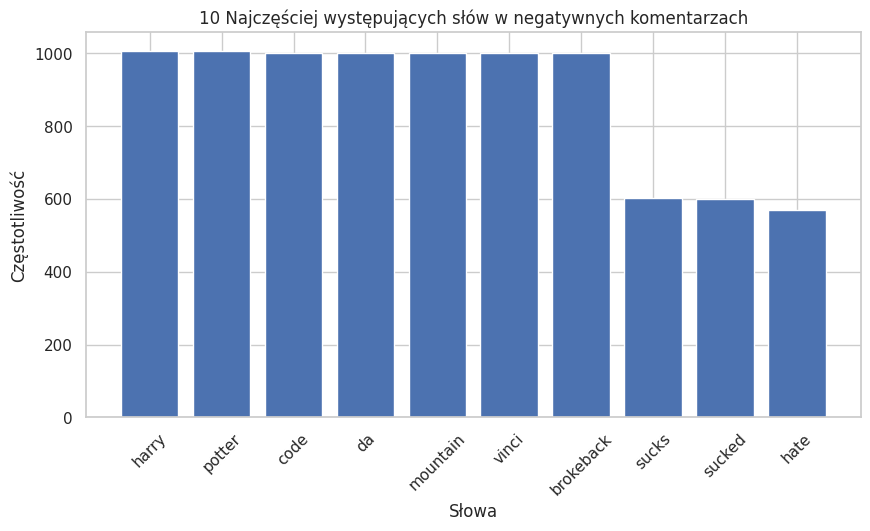

In [219]:
vectorizer = CountVectorizer(stop_words='english')

positive_comments = train_data_df[train_data_df['sentiment'] == 1]['comment']
positive_matrix = vectorizer.fit_transform(positive_comments)
positive_freq = zip(vectorizer.get_feature_names_out(), positive_matrix.sum(axis=0).tolist()[0])
positive_freq = sorted(positive_freq, key=lambda x: -x[1])

negative_comments = train_data_df[train_data_df['sentiment'] == 0]['comment']
negative_matrix = vectorizer.fit_transform(negative_comments)
negative_freq = zip(vectorizer.get_feature_names_out(), negative_matrix.sum(axis=0).tolist()[0])
negative_freq = sorted(negative_freq, key=lambda x: -x[1])

#Create histogram for top frequent words in positive comments
labels_pos, values_pos = zip(*positive_freq[:10])
plt.figure(figsize=(10,5))
plt.bar(labels_pos, values_pos)
plt.title('10 Najczęściej występujących słów w pozytywnych komentarzach')
plt.ylabel('Częstotliwość')
plt.xlabel('Słowa')
plt.xticks(rotation=45)
plt.show()
#Create histogram for top frequent words in negative comments
labels_neg, values_neg = zip(*negative_freq[:10])
plt.figure(figsize=(10,5))
plt.bar(labels_neg, values_neg)
plt.title('10 Najczęściej występujących słów w negatywnych komentarzach')
plt.ylabel('Częstotliwość')
plt.xlabel('Słowa')
plt.xticks(rotation=45)
plt.show()

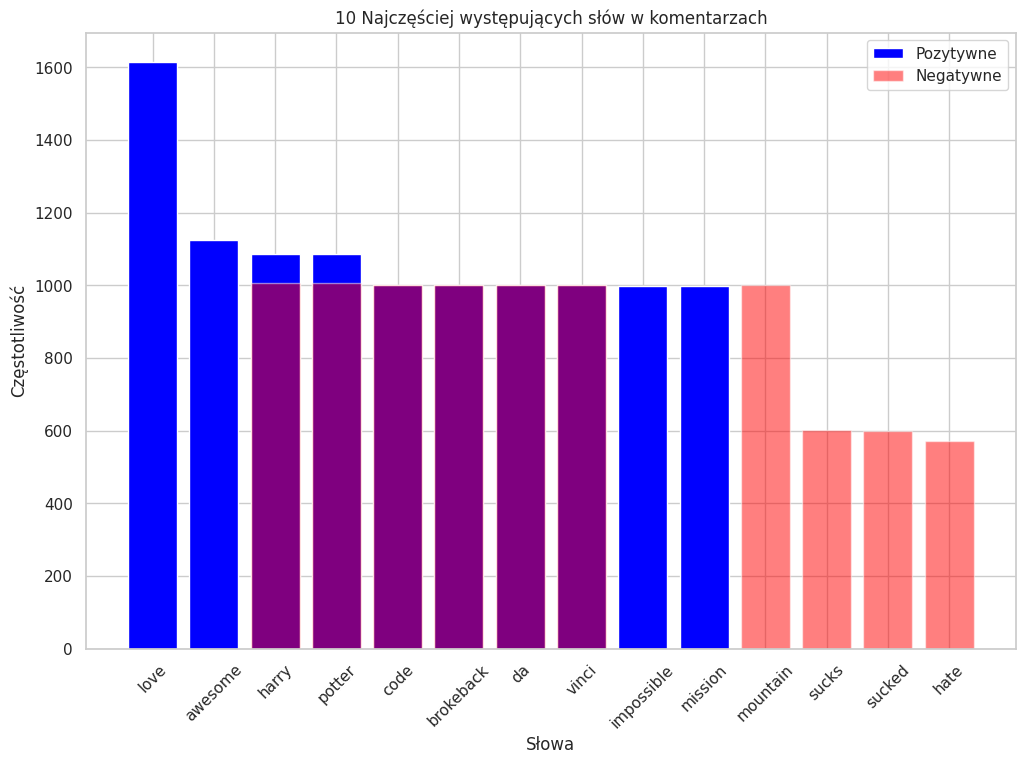

In [220]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(labels_pos, values_pos, color='blue', label='Pozytywne')
ax.bar(labels_neg, values_neg, color='red', label='Negatywne', alpha=0.5)
ax.set_title('10 Najczęściej występujących słów w komentarzach')
ax.set_ylabel('Częstotliwość')
ax.set_xlabel('Słowa')
ax.legend()
plt.xticks(rotation=45)
plt.show()

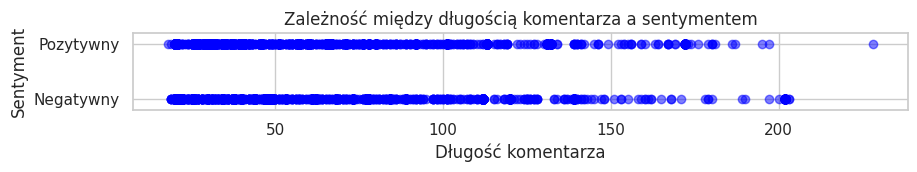

In [221]:
plt.figure(figsize=(10, 1))
plt.scatter(train_data_df['comment'].apply(len), train_data_df['sentiment'], color='blue', alpha=0.5)  # Ustawienie przezroczystości dla lepszej widoczności przy nakładaniu się punktów
plt.title('Zależność między długością komentarza a sentymentem')
plt.xlabel('Długość komentarza')
plt.ylabel('Sentyment')
plt.yticks([0, 1], ["Negatywny", "Pozytywny"])
plt.ylim(-0.2, 1.2)
plt.grid(True)
plt.show()

In [222]:
defaultdict(list)

defaultdict(list, {})

In [223]:
#Dictionary to store sentiment lists for every word
sentiment_dict = defaultdict(list)

rows = []
for _, row in train_data_df.iterrows():
    words = row['comment'].lower().split()
    for word in words:
        sentiment_dict[word].append(row['sentiment'])

def determine_color(sentiments):
    if all(s == 1 for s in sentiments):
        return 'green'
    elif all(s == 0 for s in sentiments):
        return 'red'
    else:
        return 'orange'

color_dict = {word: determine_color(sentiments) for word, sentiments in sentiment_dict.items()}

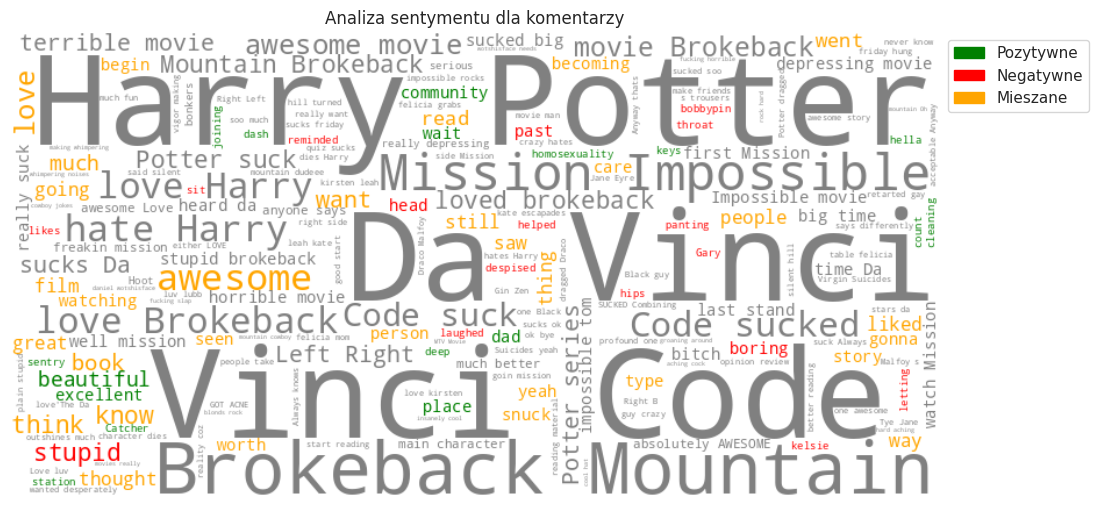

In [224]:
#Function color_func use color dictionary
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return color_dict.get(word.lower(), 'grey')

text = ' '.join(train_data_df['comment'])

wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(text)
legend_elements = [
    mpatches.Patch(color='green', label='Pozytywne'),
    mpatches.Patch(color='red', label='Negatywne'),
    mpatches.Patch(color='orange', label='Mieszane')
]
plt.figure(figsize=(12, 7))
#plt.subplot(121)  # Użyj subplot, aby zrobić miejsce na legendę
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Analiza sentymentu dla komentarzy')
plt.axis('off')
plt.show()


In [225]:
#Preprocessing

In [226]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [227]:
def tokenize(text):
    text = re.sub("[^a-zA-Z]", " ", text) #remove non letters
    tokens = nltk.word_tokenize(text) #tokenize
    stems = stem_tokens(tokens, PorterStemmer()) #stem
    return stems

In [228]:
count_vect = CountVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, stop_words='english', max_features=100)
#fits the model, model learns the vocabulary and transforms corpus data into feature vectors
comment_tf = count_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
#to numpy
comment_tf_nd = comment_tf.toarray()
comment_tf_nd.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

(40138, 100)

In [229]:
print("Comments term frequency (CountVectorize): ")
pd.DataFrame(comment_tf_nd, columns=count_vect.get_feature_names_out()).head(5)

Comments term frequency (CountVectorize): 


,aaa,airlin,amaz,angelina,awesom,beauti,becaus,big,boston,brokeback,...,toyota,ucla,ve,vinci,wa,want,way,whi,work,world
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [230]:
tfidf_vect = TfidfVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, stop_words='english', max_features=100, smooth_idf=False)
comment_tfidf = tfidf_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
comment_tfidf_nd = comment_tfidf.toarray()
comment_tfidf_nd.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

(40138, 100)

In [231]:
print("Comments term frequency-inverse document frequency (tf-idf):")
pd.DataFrame(comment_tfidf_nd, columns=tfidf_vect.get_feature_names_out()).head(5)

Comments term frequency-inverse document frequency (tf-idf):


,aaa,airlin,amaz,angelina,awesom,beauti,becaus,big,boston,brokeback,...,toyota,ucla,ve,vinci,wa,want,way,whi,work,world
0,0.0,0.0,0.0,0.0,0.391895,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.442319,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.384584,0.310759,0.272596,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.420995,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.420995,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.421334,0.000000,0.0,0.0,0.0,0.0,0.0


In [232]:
#words in vocabulary
vocab = count_vect.get_feature_names_out()
print(vocab)

['aaa' 'airlin' 'amaz' 'angelina' 'awesom' 'beauti' 'becaus' 'big'
 'boston' 'brokeback' 'car' 'citi' 'clinton' 'code' 'cool' 'crappi'
 'cruis' 'd' 'da' 'doe' 'don' 'drive' 'francisco' 'friend' 'fuck' 'fun'
 'geico' 'god' 'good' 'got' 'great' 'guy' 'ha' 'harri' 'harvard' 'hate'
 'hi' 'hilton' 'honda' 'imposs' 'joli' 'just' 'know' 'laker' 'left' 'like'
 'littl' 'london' 'look' 'lot' 'love' 'm' 'macbook' 'make' 'miss'
 'mission' 'mit' 'mountain' 'movi' 'na' 'need' 'new' 'oh' 'onli' 'pari'
 'peopl' 'person' 'potter' 'pretti' 'purdu' 'realli' 'right' 'rock' 's'
 'said' 'san' 'say' 'school' 'seattl' 'shanghai' 'shitti' 'stori' 'stupid'
 'suck' 't' 'thi' 'thing' 'think' 'time' 'tom' 'toyota' 'ucla' 've'
 'vinci' 'wa' 'want' 'way' 'whi' 'work' 'world']


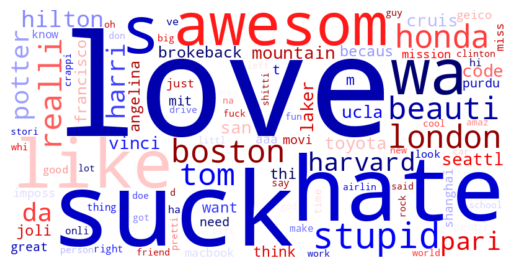

In [233]:
sum_vocab = np.sum(comment_tf_nd, axis=0)
word_frequencies = dict(zip(vocab, sum_vocab))
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap='seismic',).generate_from_frequencies(word_frequencies)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [234]:
# find some good and bad words
df = pd.DataFrame(comment_tf_nd, columns=count_vect.get_feature_names_out())
selected_words = ['awesom', 'good', 'great', 'like', 'shitti', 'stupid', 'suck']
sum_data = dict()
for word in selected_words:
    sum_data[word] = df[word].sum()
#sum_data
df_subset = df[selected_words]
X_train, X_test, y_train, y_test  = train_test_split(df_subset[0:len(train_data_df)], train_data_df.sentiment,
                                                     train_size=0.75, random_state=1,
                                                     stratify=train_data_df.sentiment)

# Create and train the Logistic Regression Classifier
log_sw_model = LogisticRegression()
log_sw_model = log_sw_model.fit(X=X_train, y=y_train)

y_pred = log_sw_model.predict(X=X_test)
y_pred_prob_sw = log_sw_model.predict_proba(X=X_test)[:,1]
fpr_sw, tpr_sw, thresholds = metrics.roc_curve(y_test, y_pred_prob_sw)
roc_auc_sw = metrics.auc(fpr_sw, tpr_sw)

In [235]:
#tf-idf linear classifier
# train and validation set split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(comment_tfidf_nd[0:len(train_data_df)],
                                                                             train_data_df.sentiment,
                                                                             train_size=0.75,
                                                                             random_state=1,
                                                                             stratify=train_data_df.sentiment)

log_tfidf_model = LogisticRegression()
log_tfidf_model = log_tfidf_model.fit(X=X_train_tfidf, y=y_train_tfidf)
# classifier to label an evaluation set
y_pred_tfidf = log_tfidf_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf = log_tfidf_model.predict_proba(X=X_test_tfidf)[:,1]

print(metrics.classification_report(y_test_tfidf, y_pred_tfidf))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       773
           1       0.98      0.99      0.99       999

    accuracy                           0.98      1772
   macro avg       0.98      0.98      0.98      1772
weighted avg       0.98      0.98      0.98      1772



In [236]:
fpr_tfidf, tpr_tfidf, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf)
roc_auc_tfidf = metrics.auc(fpr_tfidf, tpr_tfidf)
roc_auc_tfidf

0.9984350456536742

In [237]:
#tf linear classifier
# train and validation set split
X_train_tf, X_test_tf, y_train_tf, y_test_tf  = train_test_split(comment_tf_nd[0:len(train_data_df)],
                                                                 train_data_df.sentiment,
                                                                 train_size=0.75,
                                                                 random_state=1,
                                                                 stratify=train_data_df.sentiment)

log_tf_model = LogisticRegression()
log_tf_model = log_tf_model.fit(X=X_train_tf, y=y_train_tf)
# classifier to label an evaluation set
y_pred_tf = log_tf_model.predict(X=X_test_tf)
y_pred_prob_tf = log_tf_model.predict_proba(X=X_test_tf)[:,1]

print(metrics.classification_report(y_test_tf, y_pred_tf))
fpr_tf, tpr_tf, thresholds = metrics.roc_curve(y_test_tf, y_pred_prob_tf)
roc_auc_tf = metrics.auc(fpr_tf, tpr_tf)
roc_auc_tf

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       773
           1       0.99      0.99      0.99       999

    accuracy                           0.99      1772
   macro avg       0.99      0.99      0.99      1772
weighted avg       0.99      0.99      0.99      1772



0.9978814519564843

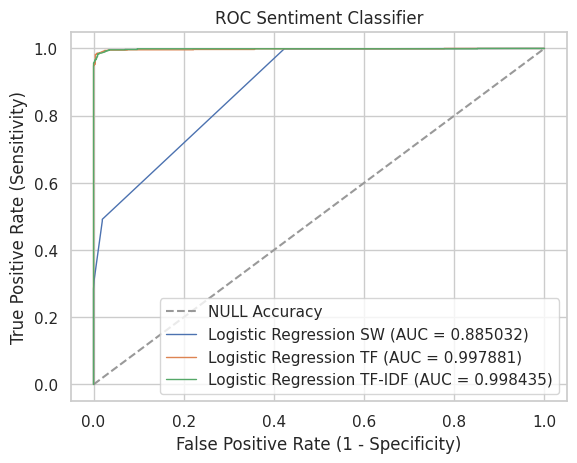

In [238]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_sw, tpr_sw, lw=1, label='Logistic Regression SW (AUC = %0.6f)' % roc_auc_sw)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [239]:
comment_tfidf_nd[0:len(train_data_df)]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [240]:
tfidf_vect = TfidfVectorizer(analyzer='word', tokenizer=tokenize, lowercase=True, stop_words='english', max_features=100, smooth_idf=True)
comment_tfidf = tfidf_vect.fit_transform(train_data_df.comment.tolist() + test_data_df.comment.tolist())
comment_tfidf_nd = comment_tfidf.toarray()
comment_tfidf_nd.shape
#tf-idf linear classifier
# train and validation set split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf  = train_test_split(comment_tfidf_nd[0:len(train_data_df)], train_data_df.sentiment, train_size=0.75, random_state=1, stratify=train_data_df.sentiment)

# Logistic Regression Classifier
log_tfidf_model = LogisticRegression()
log_tfidf_model = log_tfidf_model.fit(X=X_train_tfidf, y=y_train_tfidf)
# classifier to label an evaluation set
y_pred_tfidf = log_tfidf_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf = log_tfidf_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_smooth, tpr_tfidf_smooth, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf)
roc_auc_tfidf_smooth = metrics.auc(fpr_tfidf_smooth, tpr_tfidf_smooth)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', '

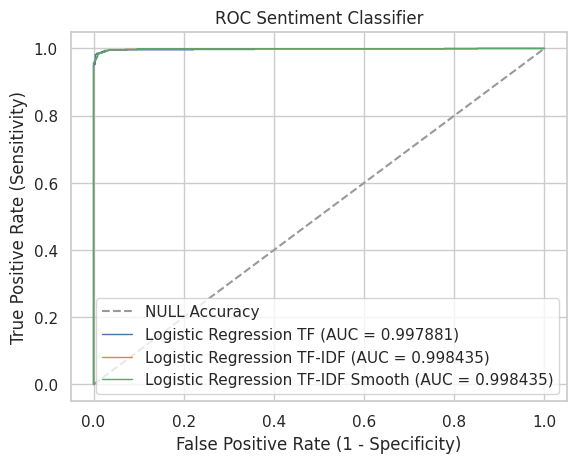

In [241]:
# ROC curves of both the Classifiers
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tfidf_smooth, tpr_tfidf_smooth, lw=1, label='Logistic Regression TF-IDF Smooth (AUC = %0.6f)' % roc_auc_tfidf_smooth)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [242]:
#Predicted unlabelled data
#Get predictions
test_pred = log_tfidf_model.predict(comment_tfidf_nd[len(train_data_df):])
#Let's sample some of them
spl = random.sample(range(len(test_pred)), 15)

for text, sentiment in zip(test_data_df.comment[spl], test_pred[spl]):
    print(sentiment, text)

1 The purdue jazz band was awesome.
0 Seattle sucks in bumper to bumper if you're on a hill with a stick shift.
1 I liked Tom Cruise until he dumped Nicole Kidman.
0 ucla sucks!
0 I really miss seattle and hk recently....
0 I really hate Tom Cruise.
0 Paris Hilton – Sexy, relevant to a different kind of Bar...
0 Purdue is an ugly campus anyway...
1 She also said she didnt miss her Thanksgiving because Geico was so great and he goes " MASHED POTATOES AND CRANBERRY SAUCE!!!!
0 usually, i can't at my house but i'm at the library but i moved into my aunts house in san carlos to go to school here because schools in san francisco sucks BIG TIME!
0 stupid lakers...
0 today we found out that the stupid purdue college kids made a mistake in the competition and we actually got 6th place in state!
1 And I love the Honda NSX.
1 angelina jolie is so beautiful that i don't even have the desire to attain such exquisite beauty..
1 I love Harvard guys...


In [243]:
sia = SentimentIntensityAnalyzer()

train_data_df['vader_score'] = train_data_df['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
fpr_vader, tpr_vader, thresholds_vader = metrics.roc_curve(train_data_df['sentiment'], train_data_df['vader_score'])
roc_auc_vader = auc(fpr_vader, tpr_vader)

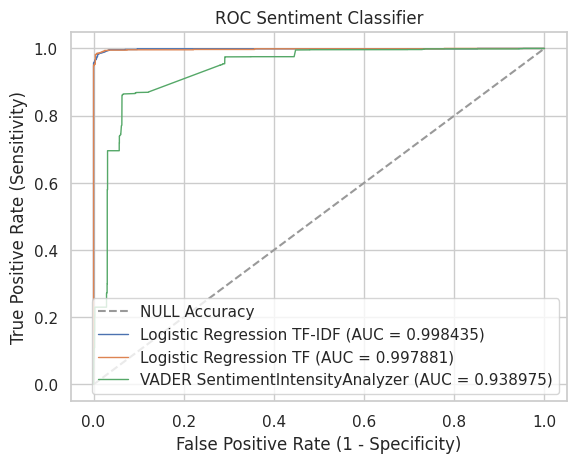

In [244]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [245]:
#Lemmatization with VADER
#Lemmatize the entire text without dividing it into sentences -> This simplifies the process, but may not take into account some of the linguistic nuances that arise from sentence structure.
#Lemmatization without specifying the part of speech

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])

In [246]:
train_data_df['lemmatized_comment'] = train_data_df['comment'].apply(lemmatize_text)

sia = SentimentIntensityAnalyzer()

train_data_df['vader_lemma_score'] = train_data_df['lemmatized_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
fpr_lemmatizer, tpr_lemmatizer, thresholds = roc_curve(train_data_df['sentiment'], train_data_df['vader_lemma_score'])
roc_auc_lemmatizer = metrics.auc(fpr_lemmatizer, tpr_lemmatizer)

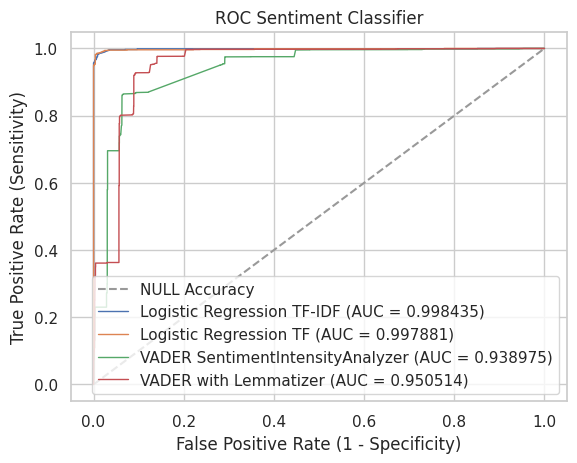

In [247]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [248]:
#Definition of the lemmatization function divided into sentences
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    sentences = sent_tokenize(text)
    lemmatized_output = []

    for sentence in sentences:
        words = word_tokenize(sentence)
        lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word) for word in words])
        lemmatized_output.append(lemmatized_sentence)

    return ' '.join(lemmatized_output)

In [249]:
from nltk.tokenize import sent_tokenize, word_tokenize
train_data_df['lemmatized_div_comment'] = train_data_df['comment'].apply(lemmatize_text)

sia = SentimentIntensityAnalyzer()

train_data_df['vader_lemma_div_score'] = train_data_df['lemmatized_div_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
fpr_lem_div, tpr_lem_div, thresholds = metrics.roc_curve(train_data_df['sentiment'], train_data_df['vader_lemma_div_score'])
roc_auc_lem_div = metrics.auc(fpr_lem_div, tpr_lem_div)

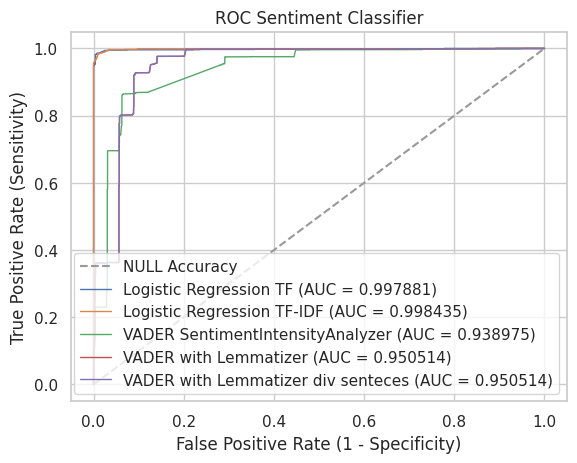

In [250]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [ ]:
# from nltk import pos_tag

# def get_wordnet_pos(word):
#     """Mapowanie tagu POS do pierwszego znaku, który rozumie lemmatizer WordNet."""
#     tag = pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": nltk.corpus.wordnet.ADJ,
#                 "N": nltk.corpus.wordnet.NOUN,
#                 "V": nltk.corpus.wordnet.VERB,
#                 "R": nltk.corpus.wordnet.ADV}

#     return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

# def lemmatize_text(text):
#     lemmatizer = WordNetLemmatizer()
#     word_tokens = word_tokenize(text)
#     lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokens])
#     return lemmatized_output


In [263]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(word):
    """Map NLTK POS tag to a format recognized by WordNetLemmatizer"""
    tag = pos_tag([word])[0][1][0].upper()  # Get the first character of the POS tag
    tag_dict = {
        "J": corpus.wordnet.ADJ,
        "N": corpus.wordnet.NOUN,
        "V": corpus.wordnet.VERB,
        "R": corpus.wordnet.ADV
    }
    return tag_dict.get(tag, corpus.wordnet.NOUN)  # Default to noun if no match

# Function to lemmatize text with proper POS tagging
def lemmatize_text(text):
    """Lemmatize text with POS tag mapping for better accuracy"""
    sentences = sent_tokenize(text)
    lemmatized_text = []

    # Process each sentence
    for sentence in sentences:
        words = word_tokenize(sentence)
        lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words])
        lemmatized_text.append(lemmatized_sentence)

    return ' '.join(lemmatized_text)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
train_data_df['lemmatized2_comment'] = train_data_df['comment'].apply(lemmatize_text)

sia = SentimentIntensityAnalyzer()

train_data_df['lemma2__score'] = train_data_df['lemmatized2_comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
fpr_lem2, tpr_lem2, thresholds = metrics.roc_curve(train_data_df['sentiment'], train_data_df['lemma2__score'])
roc_auc_lem2 = metrics.auc(fpr_lem2, tpr_lem2)

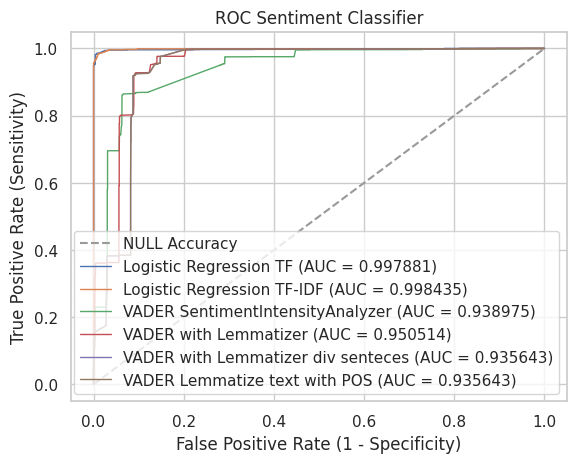

In [264]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_lem2, tpr_lem2, lw=1, label='VADER Lemmatize text with POS (AUC = %0.6f)' % roc_auc_lem2)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [251]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_tfidf, y_train_tfidf)

#Classifier to label an evaluation set
y_pred_tfid_knn = knn_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf_knn = knn_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_knn, tpr_tfidf_knn, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_knn)
roc_auc_tfidf_knn = metrics.auc(fpr_tfidf_knn, tpr_tfidf_knn)

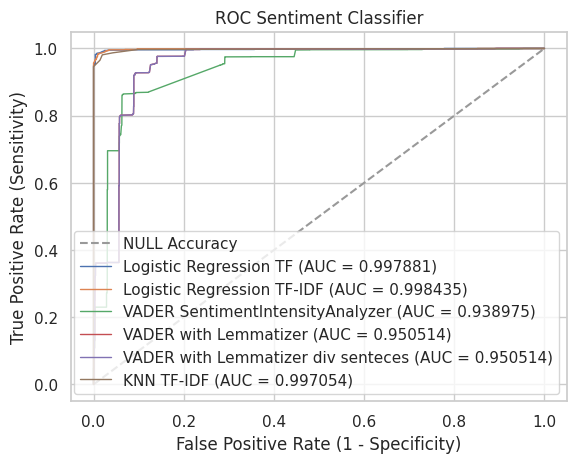

In [252]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [253]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train_tfidf)

#Classifier to label an evaluation set
y_pred_tfid_dt = dt_model.predict(X=X_test_tfidf)
y_pred_prob_tfidf_dt = dt_model.predict_proba(X=X_test_tfidf)[:,1]
fpr_tfidf_dt, tpr_tfidf_dt, thresholds = metrics.roc_curve(y_test_tfidf, y_pred_prob_tfidf_knn)
roc_auc_tfidf_dt = metrics.auc(fpr_tfidf_dt, tpr_tfidf_dt)

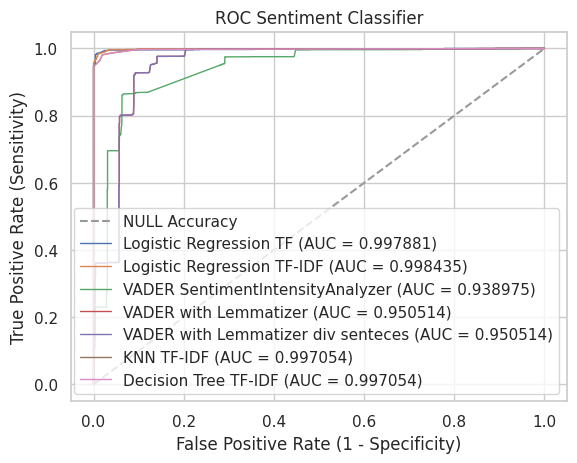

In [254]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [255]:
# Preprocessing parameters
vocab_size = 20000  # Max number of words in dict
max_length = 100    # Max length sequence

# Tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data_df.comment)

# Convert txt to sequence
X = tokenizer.texts_to_sequences(train_data_df.comment)
X = pad_sequences(X, maxlen=max_length)

y = train_data_df.sentiment.values

# Train, validation set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [256]:
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_cnn.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

y_pred_prob_cnn = model_cnn.predict(X_test).flatten()
fpr_cnn, tpr_cnn, thresholds = roc_curve(y_test, y_pred_prob_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

print(f"ROC AUC: {roc_auc_cnn}")


Epoch 1/5
149/149 [==============================] - 6s 34ms/step - loss: 0.2885 - auc: 0.9798 - val_loss: 0.0370 - val_auc: 0.9993
Epoch 2/5
149/149 [==============================] - 4s 28ms/step - loss: 0.0149 - auc: 0.9999 - val_loss: 0.0247 - val_auc: 0.9993
Epoch 3/5
149/149 [==============================] - 4s 28ms/step - loss: 0.0043 - auc: 1.0000 - val_loss: 0.0225 - val_auc: 0.9994
Epoch 4/5
149/149 [==============================] - 5s 34ms/step - loss: 0.0019 - auc: 1.0000 - val_loss: 0.0226 - val_auc: 0.9994
Epoch 5/5
74/74 [==============================] - 0s 5ms/step
ROC AUC: 0.9996456123073251


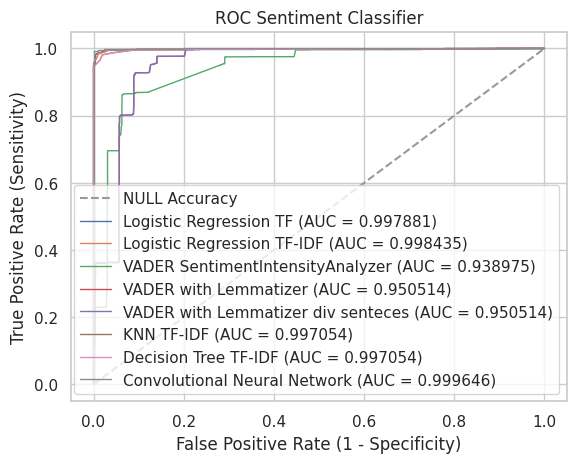

In [257]:
sns.set(style='whitegrid', context='notebook')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.plot(fpr_cnn, tpr_cnn, lw=1, label='Convolutional Neural Network (AUC = %0.6f)' % roc_auc_cnn)
plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)

In [258]:
#Recurrent Neural Network (RNN)

model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_rnn.add(SimpleRNN(units=50))
model_rnn.add(Dense(1, activation='sigmoid'))

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_rnn.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

y_pred_prob_rnn = model_rnn.predict(X_test).flatten()
fpr_rnn, tpr_rnn, thresholds = roc_curve(y_test, y_pred_prob_rnn)
roc_auc_rnn = auc(fpr_rnn, tpr_rnn)

print(f"ROC AUC: {roc_auc_rnn}")


Epoch 1/5
149/149 [==============================] - 10s 54ms/step - loss: 0.2476 - auc: 0.9741 - val_loss: 0.0978 - val_auc: 0.9952
Epoch 2/5
149/149 [==============================] - 7s 50ms/step - loss: 0.0462 - auc: 0.9992 - val_loss: 0.0743 - val_auc: 0.9966
Epoch 3/5
149/149 [==============================] - 8s 50ms/step - loss: 0.0116 - auc: 1.0000 - val_loss: 0.0530 - val_auc: 0.9984
Epoch 4/5
149/149 [==============================] - 8s 57ms/step - loss: 0.0061 - auc: 1.0000 - val_loss: 0.0653 - val_auc: 0.9970
Epoch 5/5
74/74 [==============================] - 1s 9ms/step
ROC AUC: 0.998409358819404


In [259]:
#LSTM

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_lstm.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

y_pred_prob_lstm = model_lstm.predict(X_test).flatten()
fpr_lstm, tpr_lstm, thresholds = roc_curve(y_test, y_pred_prob_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

print(f"ROC AUC: {roc_auc_lstm}")

Epoch 1/5
149/149 [==============================] - 15s 81ms/step - loss: 0.3568 - auc: 0.9509 - val_loss: 0.1358 - val_auc: 0.9929
Epoch 2/5
149/149 [==============================] - 11s 75ms/step - loss: 0.0657 - auc: 0.9988 - val_loss: 0.0652 - val_auc: 0.9974
Epoch 3/5
149/149 [==============================] - 11s 77ms/step - loss: 0.0182 - auc: 0.9999 - val_loss: 0.0504 - val_auc: 0.9984
Epoch 4/5
149/149 [==============================] - 12s 80ms/step - loss: 0.0060 - auc: 1.0000 - val_loss: 0.0492 - val_auc: 0.9978
Epoch 5/5
74/74 [==============================] - 1s 14ms/step
ROC AUC: 0.9983780234865781


In [260]:
#GRU
model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_length))
model_gru.add(GRU(units=50))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_gru.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

y_pred_prob_gru = model_gru.predict(X_test).flatten()
fpr_gru, tpr_gru, thresholds = roc_curve(y_test, y_pred_prob_gru)
roc_auc_gru = auc(fpr_gru, tpr_gru)

print(f"ROC AUC: {roc_auc_gru}")

Epoch 1/5
149/149 [==============================] - 14s 80ms/step - loss: 0.2464 - accuracy: 0.8932 - val_loss: 0.0607 - val_accuracy: 0.9765
Epoch 2/5
149/149 [==============================] - 11s 77ms/step - loss: 0.0248 - accuracy: 0.9930 - val_loss: 0.0685 - val_accuracy: 0.9833
Epoch 3/5
149/149 [==============================] - 11s 74ms/step - loss: 0.0076 - accuracy: 0.9981 - val_loss: 0.0576 - val_accuracy: 0.9773
Epoch 4/5
149/149 [==============================] - 12s 80ms/step - loss: 0.0049 - accuracy: 0.9992 - val_loss: 0.0456 - val_accuracy: 0.9880
Epoch 5/5
74/74 [==============================] - 1s 13ms/step
ROC AUC: 0.998632436545951


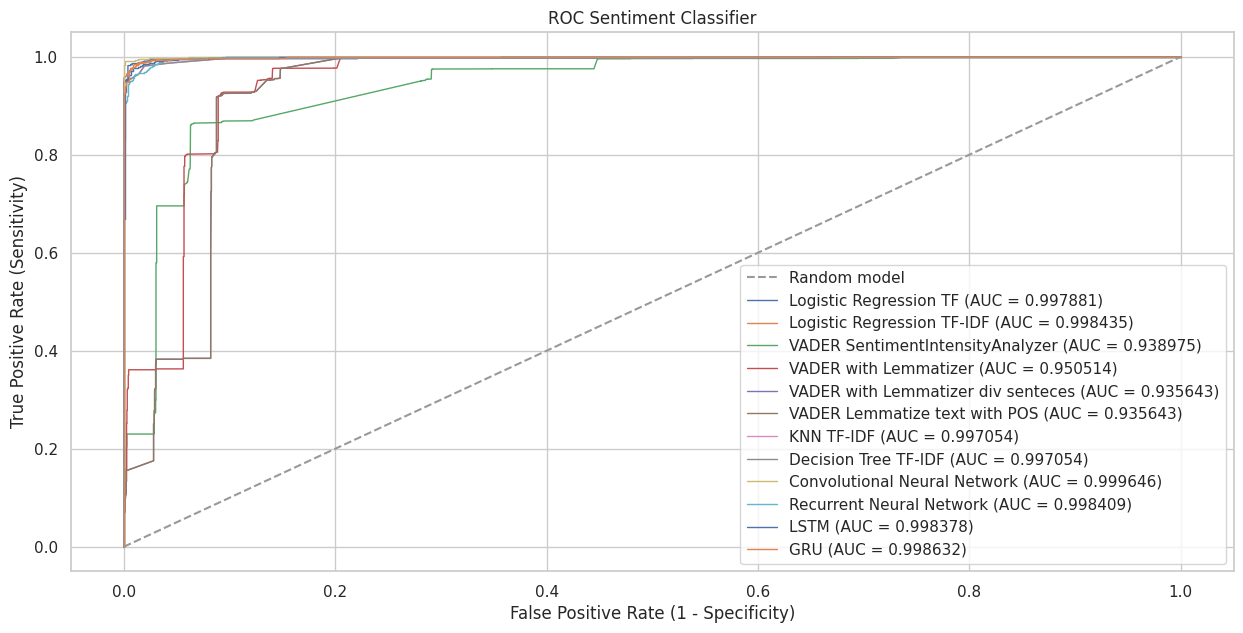

In [265]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(15, 7))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random model')
plt.plot(fpr_tf, tpr_tf, lw=1, label='Logistic Regression TF (AUC = %0.6f)' % roc_auc_tf)
plt.plot(fpr_tfidf, tpr_tfidf, lw=1, label='Logistic Regression TF-IDF (AUC = %0.6f)' % roc_auc_tfidf)
plt.plot(fpr_vader, tpr_vader, lw=1, label='VADER SentimentIntensityAnalyzer (AUC = %0.6f)' % roc_auc_vader)
plt.plot(fpr_lemmatizer, tpr_lemmatizer, lw=1, label='VADER with Lemmatizer (AUC = %0.6f)' % roc_auc_lemmatizer)
plt.plot(fpr_lem_div, tpr_lem_div, lw=1, label='VADER with Lemmatizer div senteces (AUC = %0.6f)' % roc_auc_lem_div)
plt.plot(fpr_lem2, tpr_lem2, lw=1, label='VADER Lemmatize text with POS (AUC = %0.6f)' % roc_auc_lem2)
plt.plot(fpr_tfidf_knn, tpr_tfidf_knn, lw=1, label='KNN TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_knn)
plt.plot(fpr_tfidf_dt, tpr_tfidf_dt, lw=1, label='Decision Tree TF-IDF (AUC = %0.6f)' % roc_auc_tfidf_dt)
plt.plot(fpr_cnn, tpr_cnn, lw=1, label='Convolutional Neural Network (AUC = %0.6f)' % roc_auc_cnn)
plt.plot(fpr_rnn, tpr_rnn, lw=1, label='Recurrent Neural Network (AUC = %0.6f)' % roc_auc_rnn)
plt.plot(fpr_lstm, tpr_lstm, lw=1, label='LSTM (AUC = %0.6f)' % roc_auc_lstm)
plt.plot(fpr_gru, tpr_gru, lw=1, label='GRU (AUC = %0.6f)' % roc_auc_gru)

plt.title('ROC Sentiment Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)